In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [2]:
from keras.preprocessing.image import ImageDataGenerator

In [3]:
from skimage import img_as_float
from skimage import exposure
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma
from skimage.filters import threshold_multiotsu,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing,disk
from skimage.measure import label, regionprops,find_contours
from skimage.morphology import erosion, dilation, opening, closing,disk
import cv2

c:\Users\david\miniconda3\envs\final3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
from tensorflow.keras.applications import MobileNet,VGG19,EfficientNetV2S
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten,BatchNormalization,Input,Conv2D,MaxPooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential


# LOAD DATA

In [5]:
all_xray_df = pd.read_csv('./Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('.','images*', '*.png'))}

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get) #get image path
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,.\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,.\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,.\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,.\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,.\images\00000003_000.png


# VISUALIZATION

In [6]:
# 1 image can have multiple class
label_counts = all_xray_df['Finding Labels'].value_counts()
label_counts

No Finding                                                         60361
Infiltration                                                        9547
Atelectasis                                                         4215
Effusion                                                            3955
Nodule                                                              2705
                                                                   ...  
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia        1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax         1
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax                  1
Edema|Infiltration|Pneumothorax                                        1
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax         1
Name: Finding Labels, Length: 836, dtype: int64

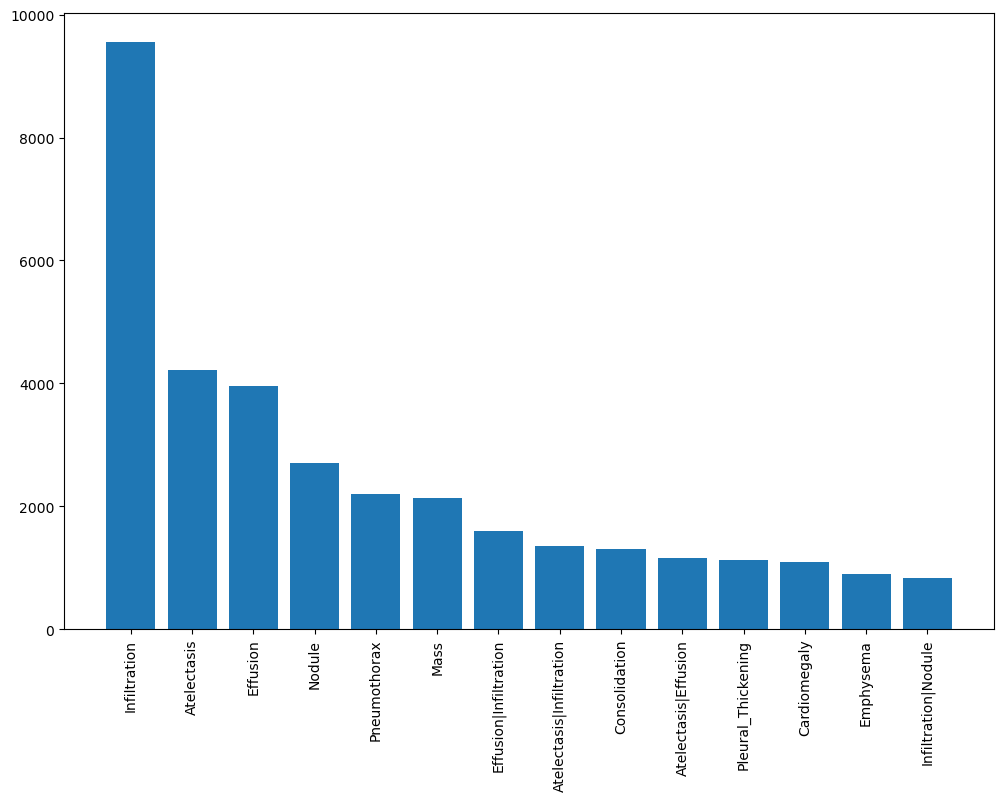

In [7]:
# Top 15 class
label_counts = all_xray_df['Finding Labels'].value_counts()[1:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

=> imbalance dataset

# DATA PROCESSING

## One-hot

In [8]:
all_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# make one-hot
for lb in all_labels:
    all_xray_df[lb] = all_xray_df['Finding Labels'].map(lambda result: 1.0 if lb in result else 0)
all_xray_df.head(20) 


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train test split

In [9]:
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)


In [10]:
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 32000 validation 8000


In [11]:
train_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
55879,00013981_003.png,Atelectasis,3,13981,67,M,PA,2790,2916,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76396,00018746_000.png,Atelectasis|Nodule|Pleural_Thickening,0,18746,57,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
13615,00003528_024.png,Atelectasis|Pneumonia,24,3528,46,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
64821,00016009_021.png,Atelectasis|Effusion|Infiltration|Mass|Pleural...,21,16009,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
81287,00019967_005.png,No Finding,5,19967,6,M,AP,2544,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Generator

In [12]:
IMAGE_SIZE = 128

In [13]:
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
DEVICES AVAILABLE: 1


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE_PER_REPLICA = 32

#We obtain the BATCH_SIZE dividing by the number of devices. 
BATCH_SIZE = BATCH_SIZE_PER_REPLICA*strategy.num_replicas_in_sync


In [15]:
core_idg = ImageDataGenerator()

In [16]:
train_generator = core_idg.flow_from_dataframe(dataframe=train_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = BATCH_SIZE,
                                        shuffle = True)
valid_generator = core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 256)

Found 32000 validated image filenames.
Found 8000 validated image filenames.


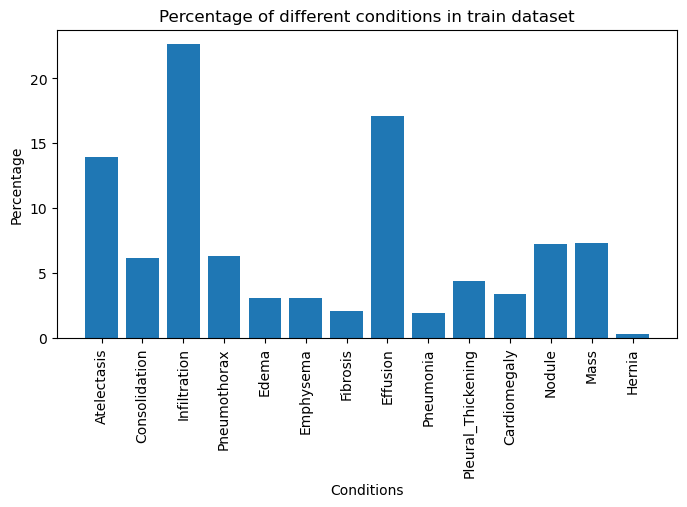

In [17]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(all_labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage of different conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()


## Convert to TF dataset

In [18]:
raw_train_data = tf.data.Dataset.from_generator(
                lambda: train_generator,
                output_types = (tf.float32, tf.float32), 
                output_shapes = ([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))


raw_valid_data = tf.data.Dataset.from_generator(
                lambda: valid_generator,
                output_types=(tf.float32, tf.float32), 
                output_shapes=([None,IMAGE_SIZE,IMAGE_SIZE,1], [None,len(all_labels)]))

In [19]:
raw_train_data

<FlatMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

In [20]:
one_batch_samples = next(iter(raw_train_data))

In [21]:
image_samples, label_samples = one_batch_samples

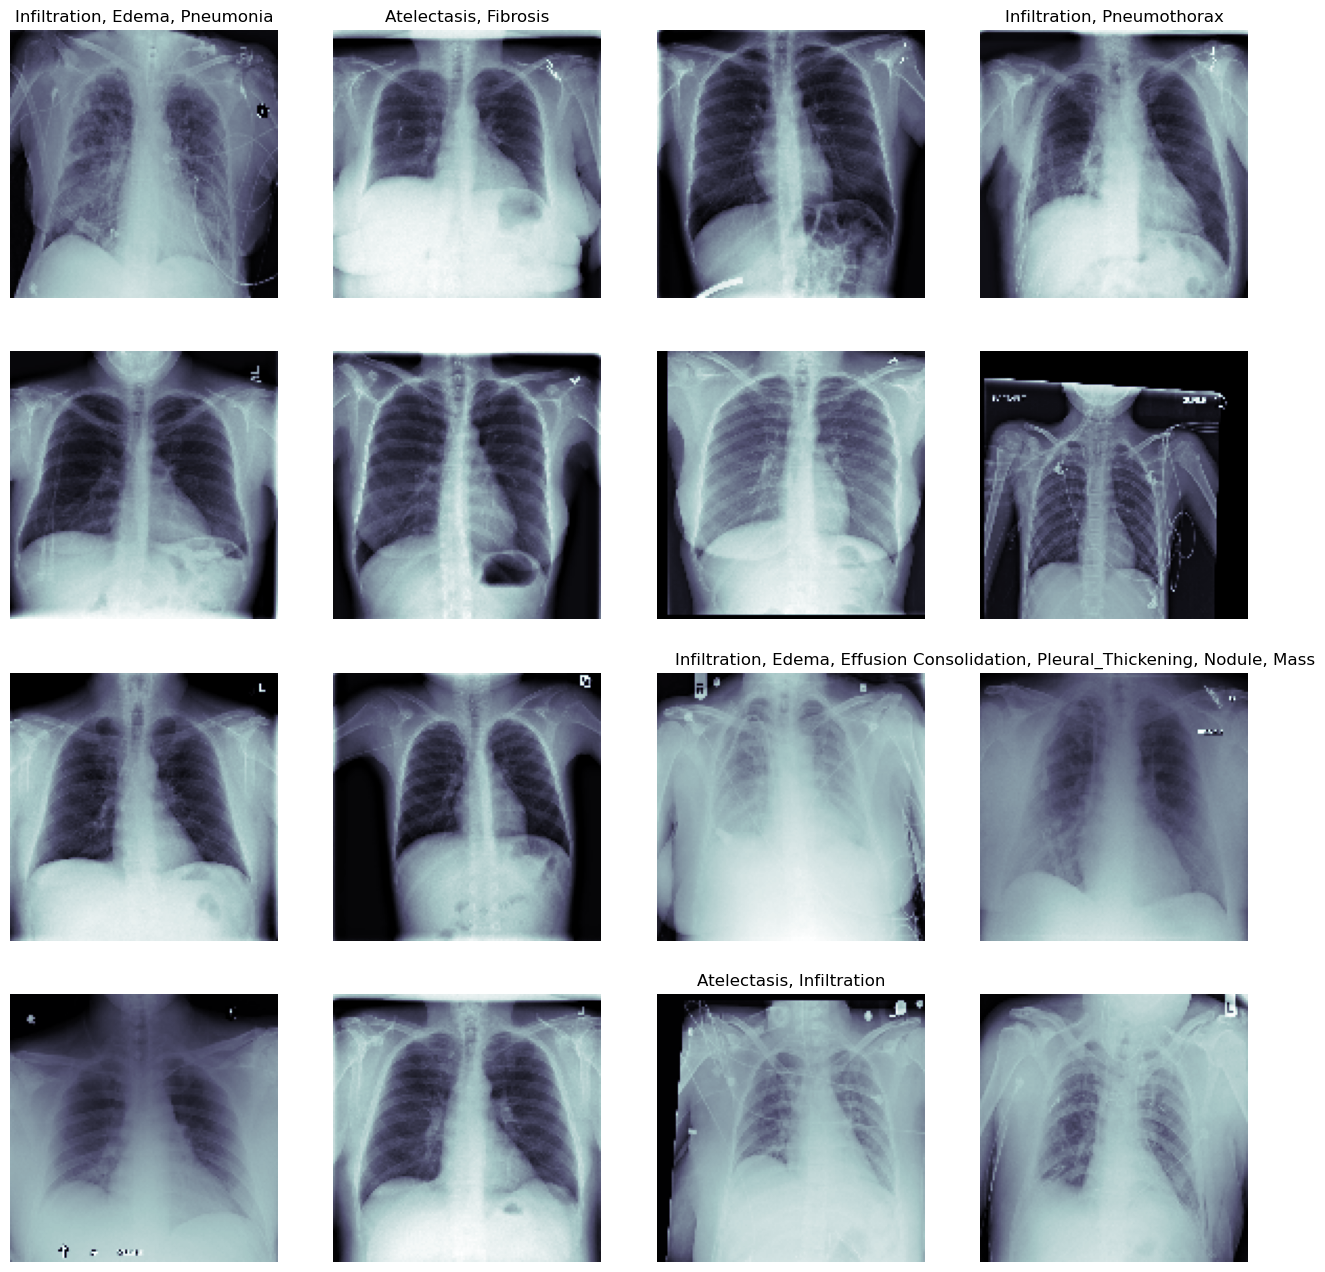

In [22]:
fig, axes = plt.subplots(4, 4, figsize = (16, 16))
for (img, lb, ax) in zip(image_samples, label_samples, axes.flatten()):
    ax.imshow(img, cmap = 'bone')
    img_lab_name = np.array(all_labels)[lb.numpy() == 1.0]
    
    ax.set_title(', '.join(img_lab_name))
    ax.axis('off')

## RESCALE

In [23]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [24]:
scale_train_data = raw_train_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)
scale_valid_data = raw_valid_data.map(lambda x,y: (normalization_layer(x),y),num_parallel_calls = AUTOTUNE)

## BACKGROUND REMOVAL

In [25]:
def background_rm(image):
    
    img_list = []
    for i in range(image.shape[0]):
        try:
            img = image[i]

            sumOfCols = np.sum(img, axis=0)
            sumOfRows = np.sum(img, axis=1)

            for i in range(len(sumOfCols)):
                if sumOfCols[i] > 0:
                    x1 = i
                    break

            for i in range(len(sumOfCols)-1,-1,-1):
                if sumOfCols[i] > 0:
                    x2 = i
                    break

            for i in range(len(sumOfRows)):
                if sumOfRows[i] > 0:
                    y1 = i
                    break

            for i in range(len(sumOfRows)-1,-1,-1):
                if sumOfRows[i] > 0:
                    y2 = i
                    break

            roi = img[y1:y2,x1:x2]
            roi = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE) (roi)
            img_list.append(roi)
        except:
            img_list.append(img)

    return tf.convert_to_tensor(tf.stack(img_list))


In [26]:
def background_rm_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(background_rm, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [27]:
rm_background_train_data = scale_train_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)
rm_background_valid_data = scale_valid_data.map(background_rm_tf,num_parallel_calls = AUTOTUNE)

## REMOVE NOISE

In [28]:
def denoise(image):
    img_list = []
    for i in range(image.shape[0]):
        img = denoise_tv_chambolle(img_as_float(image[i]), weight=0.01)
        img_list.append(img)
    return tf.convert_to_tensor(tf.stack(img_list))


In [29]:
def denoise_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(denoise, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [30]:
rm_noise_train_data = rm_background_train_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)
rm_noise_valid_data = rm_background_valid_data.map(denoise_tf,num_parallel_calls = AUTOTUNE)

In [31]:
rm_noise_train_data

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

## REMOVE THE DIAPHRAGM REGION

In [32]:
def rmDiapgRegion(image):
    img = img_as_float(image)
    img = np.copy(img)
    # get Diaphragm Region
    
    img_list = []
    for i in range(img.shape[0]):
        brightest = img[i].max()
        darkest = img[i].min()
    #     print(brightest)
        T = darkest + 0.9 * (brightest - darkest)
        binary = img[i] > T

        closed = closing(binary) 
        dilate = dilation(closed)

        # get high density region
        l = label(dilate)
        out = (l==np.bincount(l.ravel())[1:].argmax()+1).astype(np.int64)

        # smoothing region
    #     opened = closing(out)
        img[i][out.astype(np.float32) == 1.0] = 0
        img_list.append(img[i])
        
    return tf.convert_to_tensor(tf.stack(img_list))


In [33]:
def rmDiapgRegion_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(rmDiapgRegion, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [34]:
rm_diapg_train_data = rm_noise_train_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)
rm_diapg_valid_data = rm_noise_valid_data.map(rmDiapgRegion_tf,num_parallel_calls =AUTOTUNE)

In [35]:
rm_diapg_train_data

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None))>

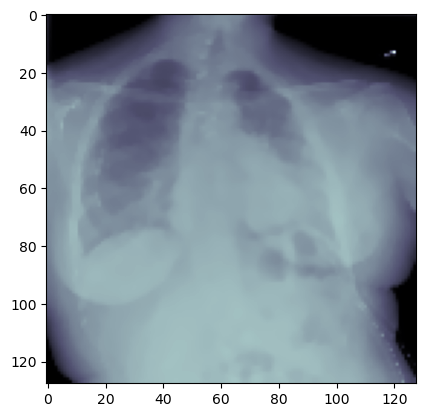

In [36]:
for image,l in rm_diapg_train_data.take(1):
    plt.imshow(image[1],cmap = 'bone')

## CONTRAST ENRICHMENT


In [37]:
def contrast_enrich(image):
    img_list = []
    for i in range(image.shape[0]):
        img = exposure.equalize_adapthist(img_as_float(image[i]),clip_limit = 0.02)
        img_list.append(img)
        
    return tf.convert_to_tensor(tf.stack(img_list))

In [38]:
def contrast_enrich_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(contrast_enrich, [image,], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [39]:
enhance_contrast_train_data = rm_diapg_train_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)
enhance_contrast_valid_data = rm_diapg_valid_data.map(contrast_enrich_tf, num_parallel_calls = AUTOTUNE)


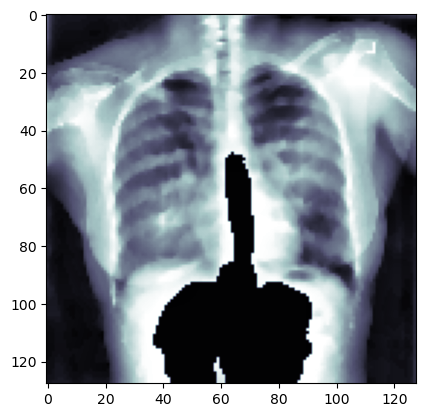

In [40]:
for image,l in enhance_contrast_train_data.take(1):
    plt.imshow(image[1],cmap = 'bone')

## LUNG SEGMENTATION

A segmentation-based cropped. This function will encourage model to focus on the lungs

In [41]:
inputs = Input((IMAGE_SIZE,IMAGE_SIZE,1))
input_resize = tf.keras.layers.Resizing(512,512, name = 'resize_input') (inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_resize)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

In [80]:
model.load_weights("./weights/cxr_reg_weights.best.hdf5")

In [43]:
def lung_segment(image):
    pred = model.predict(image,verbose = 0) > 0.4
    pred = pred.astype(np.int32) # 512,512
    img_list = []
    
    for i in range(image.shape[0]):
        l = label(pred[i])
        z = np.argpartition(np.bincount(l.ravel())[1:],-2)

        out_1 = (l== z[-2] +1).astype(int)
        out_2 = (l== z[-1] +1).astype(int)
        combine = out_1 + out_2
        combine = tf.squeeze(combine)    

        minc_local, maxc_local = 1000,0
        
        label_image = label(combine)
        regions = regionprops(label_image)

        for region in regions:
            minr, minc, maxr, maxc = region.bbox
            if minc_local > minc:
                minc_local = minc
            if maxc_local < maxc:
                maxc_local = maxc

#         if maxc_local - minc_local <= 200 or maxc_local - minc_local >= 300:
#             img_list.append(image[i])
#             continue
        img = tf.keras.layers.Resizing(512,512) (image[i])
        if minc_local - 20 >=0:
            minc_local -= 20
        if maxc_local + 20 <= img.shape[0]:
            maxc_local += 20
        z = img[:,minc_local:maxc_local]
        z = tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE,interpolation = "area") (z)
        img_list.append(z)

    return tf.convert_to_tensor(tf.stack(img_list))

In [44]:
def lung_segment_tf(image,label):
    im_shape = image.shape
    [image,] = tf.py_function(lung_segment, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label


In [45]:
lung_segment_train_data = enhance_contrast_train_data.map(lung_segment_tf, num_parallel_calls = AUTOTUNE)
lung_segment_valid_data = enhance_contrast_valid_data.map(lung_segment_tf, num_parallel_calls = AUTOTUNE)


In [46]:
def plot_lung_segment_img(image_sample):
    test_img = tf.expand_dims(image_sample,0)
    test_img /= 255.
    test_img = contrast_enrich(test_img)
    test_img = lung_segment(test_img)[0] # it return batchsize,_,_
    
    fig,axes = plt.subplots(1,2,figsize = (15,15))
    axes[0].imshow(image_sample,cmap = 'bone')
    axes[0].set_title("Original Image")
    
    axes[1].imshow(test_img,cmap = 'bone')
    axes[1].set_title("Segmentation-based cropped")


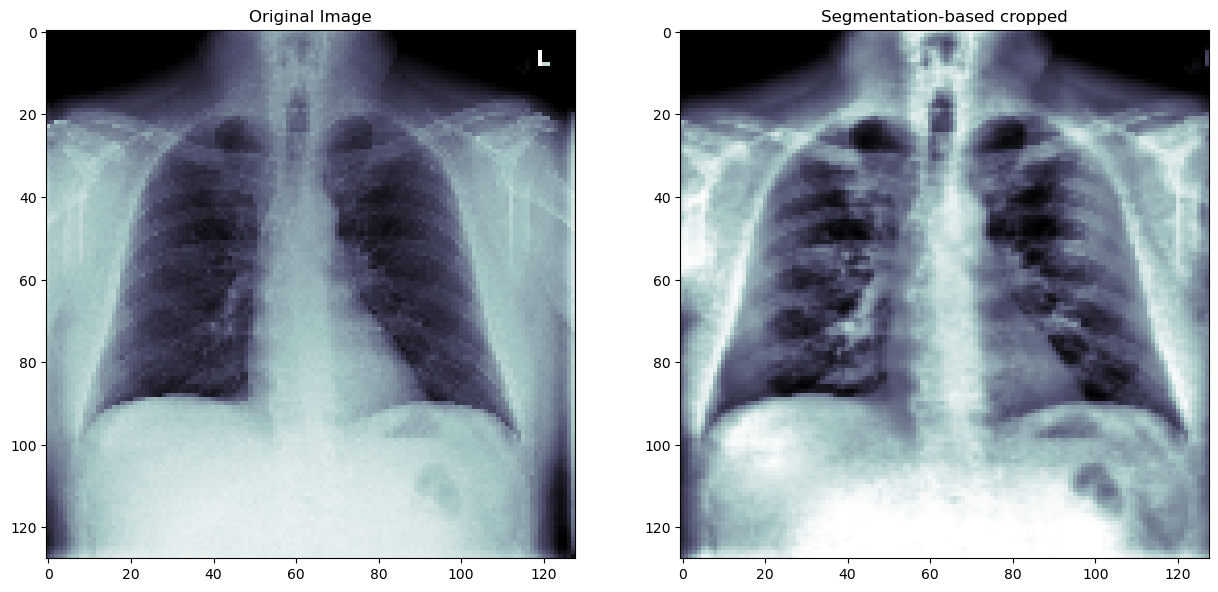

In [47]:
plot_lung_segment_img(image_samples[8])

# MODEL

In [48]:
train_data = enhance_contrast_train_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)
valid_data = enhance_contrast_valid_data.map(lambda x,y: (tf.image.grayscale_to_rgb(x),y)).cache().prefetch(buffer_size = AUTOTUNE)

In [49]:
test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                        directory=None,
                                        x_col = 'path',
                                        y_col = all_labels,
                                        class_mode = 'raw',
#                                         classes = all_labels,
                                        target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                        color_mode = 'grayscale',
                                        batch_size = 512))


Found 8000 validated image filenames.


In [50]:
test_X_normal = tf.keras.layers.Rescaling(1./255) (test_X)
test_X_normal = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_normal))

In [51]:
test_X_process = test_X.copy()

test_X_process = background_rm(test_X_process)
test_X_process = tf.keras.layers.Rescaling(1./255) (test_X_process)
# test_X_process = denoise(test_X_process.numpy())
# test_X = rmDiapgRegion(test_X)
test_X_process = contrast_enrich(test_X_process.numpy())
# test_X = lung_segment(test_X)
test_X_process = tf.image.grayscale_to_rgb(tf.convert_to_tensor(test_X_process))

## VGG19

In [52]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)
processed_input = tf.keras.applications.vgg19.preprocess_input(input)

vgg19 = VGG19(include_top = False,weights = 'imagenet') 
vgg19 = vgg19(input)

normal = BatchNormalization() (vgg19)
flatten = GlobalAveragePooling2D() (normal)

dense1 = Dense(256,activation = 'relu') (flatten)

output = Dense(len(all_labels), activation = 'sigmoid') (dense1)

vgg19_model = tf.keras.Model(inputs=[input], outputs=[output])
vgg19_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 14)                3598

In [53]:
# vgg19_model.load_weights("/kaggle/input/vgg19h5/vgg19_process_lung_2.h5")

In [54]:
vgg19_model.compile(optimizer = tf.keras.optimizers.experimental.Adam(0.001), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])

In [55]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch

1000

In [56]:
# vgg19_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

### NORMAL

In [57]:
vgg19_model.load_weights("./weights/vgg19_no2.h5")

In [58]:
y_pred_vgg19_normal = vgg19_model.predict(test_X_normal)
y_pred_vgg19_normal[:5]

16/16 [==============================] - 7s 397ms/step


array([[8.1583843e-02, 7.4258812e-02, 4.2530245e-01, 4.6509318e-02,
        7.7597722e-02, 1.4987158e-02, 1.5296822e-03, 2.4020740e-01,
        1.6520280e-02, 5.3918622e-02, 3.4764290e-02, 2.4806501e-02,
        3.5591818e-02, 5.9004447e-05],
       [7.9222538e-02, 3.1329155e-02, 2.7711409e-01, 7.8543313e-02,
        2.8291890e-02, 3.1190952e-02, 2.1803519e-03, 1.4453380e-01,
        8.9941509e-03, 4.1569307e-02, 1.2866516e-02, 3.0368034e-02,
        3.5072122e-02, 9.6556105e-05],
       [4.7067270e-02, 1.5503946e-02, 2.0334347e-01, 9.0180300e-02,
        1.0322402e-02, 3.9191041e-02, 3.1241151e-03, 7.8038774e-02,
        5.5385497e-03, 3.5288412e-02, 5.5106827e-03, 3.4474637e-02,
        3.1724680e-02, 1.2801711e-04],
       [8.9006320e-02, 3.5158884e-02, 3.0303609e-01, 6.0923994e-02,
        4.0132210e-02, 2.4079353e-02, 1.1538957e-03, 1.6543974e-01,
        9.5662912e-03, 4.2336091e-02, 1.5331573e-02, 2.2383394e-02,
        2.8522912e-02, 4.1024614e-05],
       [5.7993796e-02, 1.631

0.6095482643435337


Text(0, 0.5, 'True Positive Rate')

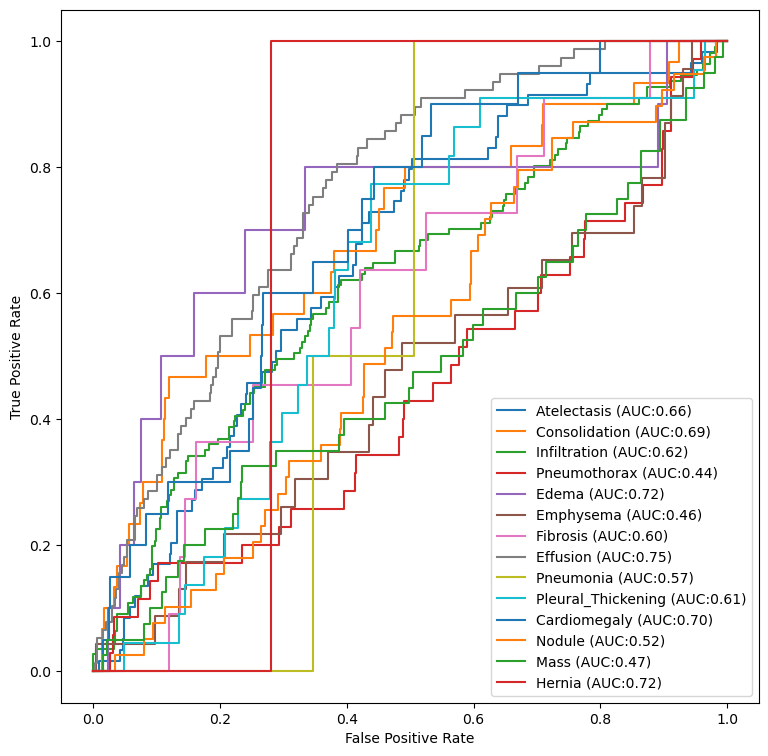

In [59]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_normal += auc(fpr, tpr)
mean_auc_vgg19_normal /= 14
print(mean_auc_vgg19_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


### PREPROCESS

In [60]:
vgg19_model.load_weights("./weights/vgg19.h5")

In [61]:
y_pred_vgg19_process = vgg19_model.predict(test_X_process)
y_pred_vgg19_process[:5]

16/16 [==============================] - 6s 396ms/step


array([[6.95163384e-02, 8.17783624e-02, 3.59884173e-01, 5.06340191e-02,
        1.69951227e-02, 4.13803495e-02, 1.16323577e-02, 7.72826970e-02,
        3.75613570e-02, 2.64608949e-01, 2.36964710e-02, 1.19539745e-01,
        9.44943950e-02, 1.88408196e-02],
       [5.28729428e-03, 5.32514369e-03, 1.86831787e-01, 3.75342136e-03,
        3.49012291e-04, 5.48646878e-03, 2.20704544e-03, 5.63062541e-03,
        3.24173295e-03, 1.69752911e-01, 1.10163633e-03, 6.43492490e-02,
        2.43986696e-02, 3.15289572e-03],
       [3.81373870e-03, 4.03825613e-03, 1.71835065e-01, 2.66356394e-03,
        2.21434544e-04, 4.20448743e-03, 1.72769465e-03, 4.02721530e-03,
        2.42039934e-03, 1.57519728e-01, 7.39482348e-04, 5.88930920e-02,
        2.02534888e-02, 2.48888461e-03],
       [1.56969149e-02, 1.82765052e-02, 2.62263894e-01, 1.29384752e-02,
        2.04544165e-03, 1.51268989e-02, 4.60465206e-03, 1.75771136e-02,
        1.08071519e-02, 2.20538989e-01, 4.29432234e-03, 8.99127275e-02,
        4.875

0.6760063396727495


Text(0, 0.5, 'True Positive Rate')

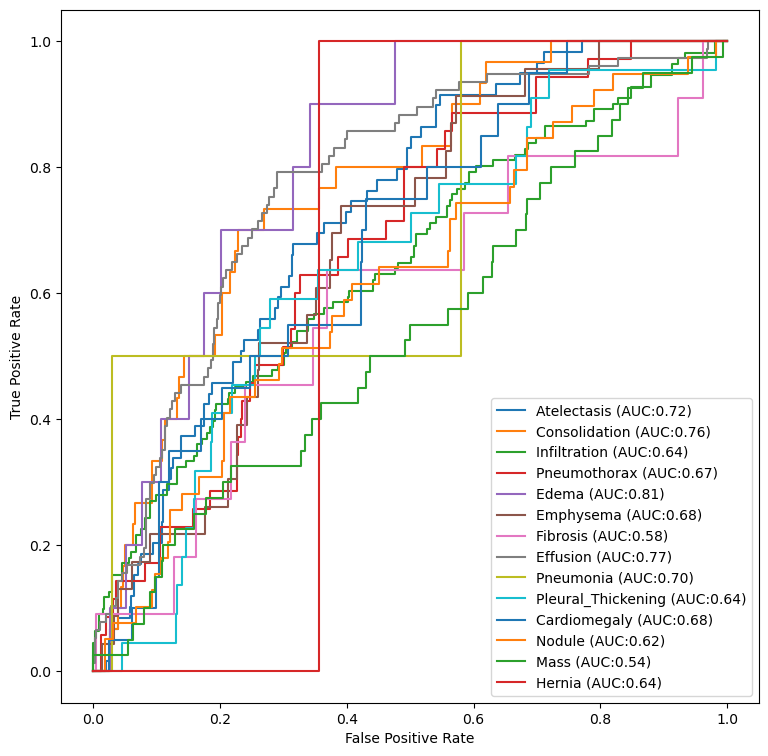

In [62]:
from sklearn.metrics import roc_curve, auc,f1_score
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_vgg19_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_vgg19_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_vgg19_process += auc(fpr, tpr)

mean_auc_vgg19_process /= 14
print(mean_auc_vgg19_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')


## EfficientNetV2S 

In [63]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32)

eff = tf.keras.applications.EfficientNetV2S(include_top = False,weights = 'imagenet') 
eff = eff(input)

normal = BatchNormalization() (eff)
flatten = GlobalAveragePooling2D() (normal)

dense1 = Dense(256,activation = 'relu') (flatten)

output = Dense(len(all_labels), activation = 'sigmoid') (dense1)

eff_model = tf.keras.Model(inputs=[input], outputs=[output])
eff_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 1280)       5120      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                           

In [64]:
eff_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(0.005), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [65]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch


1000

In [66]:
# eff_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )


### NORMAL

In [67]:
eff_model.load_weights("./weights/effv2s.h5")

In [68]:
y_pred_eff_normal = eff_model.predict(test_X_normal)
y_pred_eff_normal[:5]


16/16 [==============================] - 4s 160ms/step


array([[0.22659378, 0.1265706 , 0.3260465 , 0.09045529, 0.05987623,
        0.02210837, 0.00511651, 0.40709347, 0.0333883 , 0.04527688,
        0.03955021, 0.02730807, 0.0631292 , 0.00205859],
       [0.10245109, 0.01808541, 0.11121233, 0.05755413, 0.01066505,
        0.02625025, 0.01337607, 0.07543212, 0.00788623, 0.04433835,
        0.01047523, 0.05895117, 0.04407503, 0.00257528],
       [0.03863265, 0.00744191, 0.07192145, 0.03843946, 0.0043329 ,
        0.0186306 , 0.00907005, 0.02374515, 0.00304923, 0.02937702,
        0.00207954, 0.05315149, 0.03108445, 0.00126372],
       [0.20326187, 0.17052314, 0.42833462, 0.11216734, 0.12503304,
        0.03483322, 0.00448975, 0.3626214 , 0.04961851, 0.04306044,
        0.05100332, 0.03643491, 0.07294446, 0.00158646],
       [0.05125239, 0.00976981, 0.0797453 , 0.04424794, 0.0050667 ,
        0.0228693 , 0.01452351, 0.03908533, 0.00389922, 0.03871641,
        0.00328337, 0.06204907, 0.03911082, 0.00222245]], dtype=float32)

0.6949807942191866


Text(0, 0.5, 'True Positive Rate')

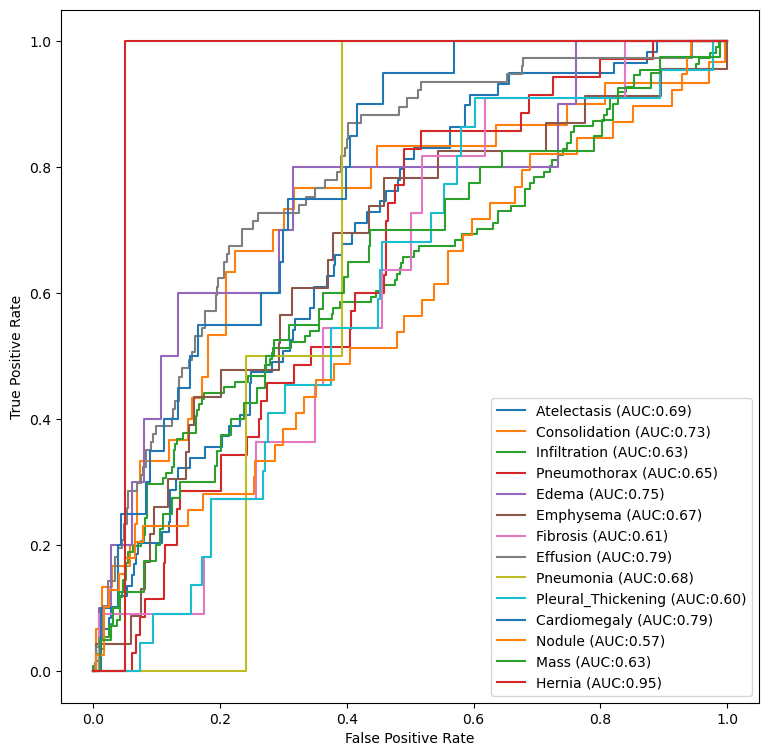

In [70]:
from sklearn.metrics import roc_curve, auc 
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_eff_normal = 0
f1_eff_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_eff_normal[:,idx])
    f1_eff_normal += f1_score(test_Y[:,idx].astype(int), y_pred_eff_normal[:,idx].astype(int))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_eff_normal += auc(fpr, tpr)

mean_auc_eff_normal /=14

print(mean_auc_eff_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS

In [71]:
eff_model.load_weights("./weights/effv2s_1.h5")

In [72]:
y_pred_eff_process = eff_model.predict(test_X_process)
y_pred_eff_process[:5]


16/16 [==============================] - 2s 152ms/step


array([[2.2765997e-01, 1.3877691e-01, 4.2455789e-01, 5.0213281e-02,
        1.0781379e-01, 2.2766380e-02, 4.9301353e-03, 2.7000993e-01,
        5.1173847e-02, 3.5457626e-02, 2.5175640e-02, 6.0009446e-02,
        3.9675552e-02, 2.3578126e-03],
       [1.1056455e-01, 2.5572285e-02, 1.5940787e-01, 1.5478086e-02,
        1.0985860e-02, 1.3123681e-02, 9.3549490e-03, 4.2207368e-02,
        1.5562260e-02, 1.5346898e-02, 1.2936343e-02, 5.4095842e-02,
        2.5306342e-02, 1.8141365e-03],
       [7.3472834e-03, 3.5249623e-03, 5.8821313e-02, 8.0856532e-03,
        4.4791109e-04, 3.2091928e-03, 1.5634064e-02, 2.9387066e-02,
        2.4707341e-03, 5.2816074e-02, 2.9145374e-03, 2.6205802e-02,
        1.8757714e-02, 7.2696246e-05],
       [2.5502995e-01, 1.2680763e-01, 3.4496450e-01, 7.5935304e-02,
        7.1581960e-02, 3.7409965e-02, 1.2465909e-02, 2.2516942e-01,
        5.3389363e-02, 4.4331715e-02, 3.3212692e-02, 7.9444803e-02,
        6.0845081e-02, 3.6137411e-03],
       [4.8564944e-02, 1.309

0.6742314750576603


Text(0, 0.5, 'True Positive Rate')

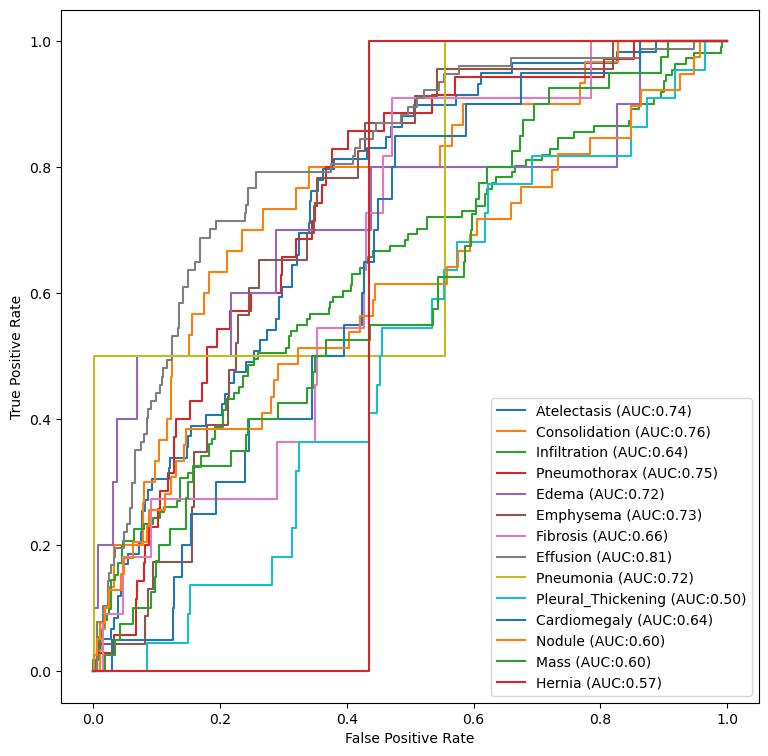

In [73]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_eff_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_eff_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_eff_process += auc(fpr, tpr)
    
mean_auc_eff_process /=14
print(mean_auc_eff_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

## ConvNet

In [76]:
import tensorflow_hub as hub

In [77]:
MODEL_PATH = "https://tfhub.dev/sayakpaul/convnext_base_21k_1k_224_fe/1"

In [78]:
input = tf.keras.layers.Input([IMAGE_SIZE, IMAGE_SIZE, 3], dtype = tf.float32, name = 'input')
input_conv = tf.keras.layers.Resizing(224,224, name = 'resize_input') (input)

hub_layer = hub.KerasLayer(MODEL_PATH, trainable=True, name = "ConvNet")
conv_model = hub_layer (input_conv)

dense1 = Dense(768, activation = tf.keras.activations.gelu, name = "dense_768") (conv_model)
dense1 = Dense(512, activation = tf.keras.activations.gelu, name = "dense_512") (dense1)
dense1 = Dense(128, activation = tf.keras.activations.gelu, name = "dense_128") (dense1)
output = Dense(len(all_labels), activation = 'sigmoid',name = 'output') (dense1)

conv_model = tf.keras.Model(inputs=[input], outputs=[output])
conv_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 3)]     0         
                                                                 
 resize_input (Resizing)     (None, 224, 224, 3)       0         
                                                                 
 ConvNet (KerasLayer)        (None, 1024)              87566464  
                                                                 
 dense_768 (Dense)           (None, 768)               787200    
                                                                 
 dense_512 (Dense)           (None, 512)               393728    
                                                                 
 dense_128 (Dense)           (None, 128)               65664     
                                                                 
 output (Dense)              (None, 14)                1806

In [79]:
conv_model.compile(optimizer = tf.keras.optimizers.experimental.AdamW(3e-4), loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', tf.keras.metrics.AUC()])


In [81]:
steps_per_epoch = train_df.shape[0]  // BATCH_SIZE
steps_per_epoch


1000

In [82]:
# conv_model.fit(train_data, 
#             steps_per_epoch = steps_per_epoch,
# #           validation_data = valid_data, 
#             epochs = 1, 
#             verbose = 1,
#           )

### NORMAL

In [83]:
conv_model.load_weights('./weights/convnet/my_checkpoint')

In [84]:
y_pred_conv_normal = conv_model.predict(test_X_normal)
y_pred_conv_normal[:5]


16/16 [==============================] - 26s 2s/step


array([[0.14834234, 0.22094178, 0.5138623 , 0.01964355, 0.09748352,
        0.00706637, 0.00762692, 0.21189328, 0.04372203, 0.0206616 ,
        0.04146745, 0.03531848, 0.04810888, 0.00137324],
       [0.4049946 , 0.12057751, 0.39311463, 0.05934387, 0.02604338,
        0.02368345, 0.01715001, 0.57635754, 0.01904335, 0.05488274,
        0.02943716, 0.03712779, 0.09730932, 0.00367274],
       [0.02249933, 0.00956706, 0.11803184, 0.00322777, 0.00109598,
        0.00196231, 0.00613394, 0.00664232, 0.00471301, 0.0068913 ,
        0.00497126, 0.02688774, 0.00861226, 0.00169406],
       [0.33817172, 0.14072841, 0.4844141 , 0.08683866, 0.05700641,
        0.04335771, 0.01647861, 0.22738701, 0.03417846, 0.03731006,
        0.02404269, 0.07276936, 0.16250344, 0.00499506],
       [0.09096753, 0.01493969, 0.16822992, 0.01621613, 0.00267192,
        0.01106772, 0.02011143, 0.01999232, 0.00657043, 0.01974792,
        0.00533181, 0.05593744, 0.04118974, 0.00846624]], dtype=float32)

0.7807758738433094


Text(0, 0.5, 'True Positive Rate')

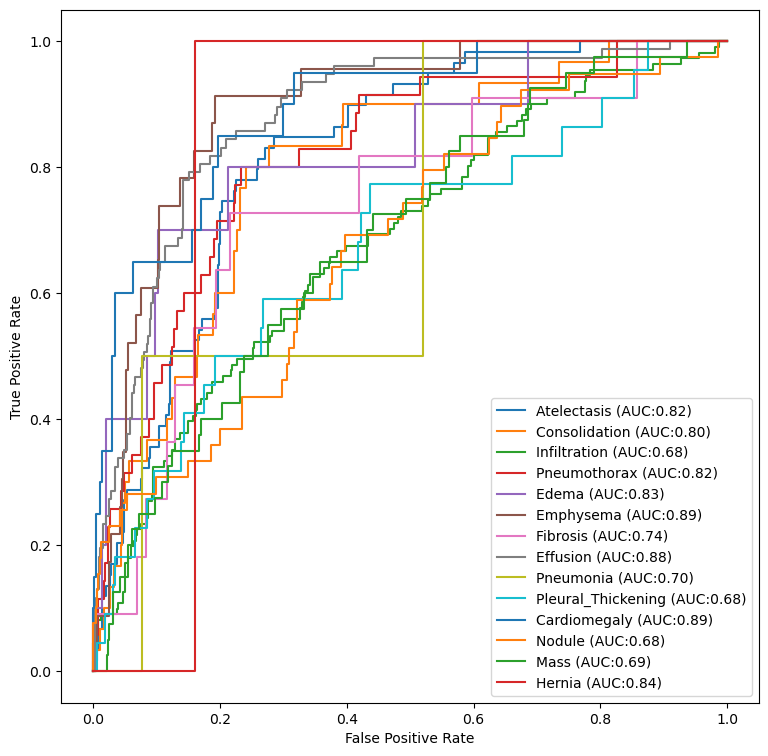

In [85]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_conv_normal = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_conv_normal[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_conv_normal += auc(fpr, tpr)

mean_auc_conv_normal /= 14
print(mean_auc_conv_normal)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')

### PREPROCESS

In [87]:
conv_model.load_weights('./weights/convnet/my_checkpoint')


In [88]:
y_pred_conv_process = conv_model.predict(test_X_process)
y_pred_conv_process[:5]


16/16 [==============================] - 24s 2s/step


array([[0.18225077, 0.16551515, 0.4814464 , 0.08960563, 0.05857376,
        0.03396507, 0.01791763, 0.20409614, 0.04150461, 0.05124542,
        0.0225515 , 0.07502714, 0.1451482 , 0.00473263],
       [0.30691868, 0.09700395, 0.34545496, 0.12651436, 0.02665807,
        0.06159184, 0.03132597, 0.3445955 , 0.02816648, 0.07962165,
        0.02712576, 0.06692363, 0.13396458, 0.00882446],
       [0.0750143 , 0.02881904, 0.22104408, 0.0357836 , 0.00648867,
        0.01783651, 0.02158312, 0.02698413, 0.01115628, 0.02463892,
        0.00597758, 0.07206418, 0.08587273, 0.00700369],
       [0.22508942, 0.0708318 , 0.35258114, 0.22442041, 0.02688401,
        0.09050887, 0.0320556 , 0.160451  , 0.0282223 , 0.06178294,
        0.00848118, 0.12424557, 0.26833433, 0.00929051],
       [0.19923607, 0.04549907, 0.2662311 , 0.20368513, 0.01709568,
        0.09014563, 0.04243495, 0.11087705, 0.02024218, 0.05610014,
        0.00572336, 0.12378305, 0.25547707, 0.01350553]], dtype=float32)

0.7617320723403507


Text(0, 0.5, 'True Positive Rate')

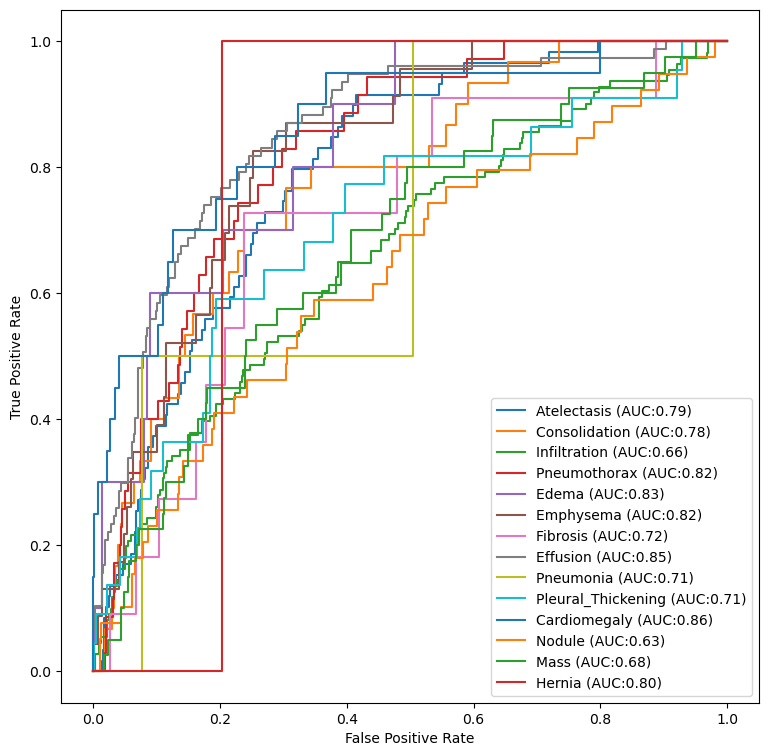

In [89]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
mean_auc_conv_process = 0
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), y_pred_conv_process[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    mean_auc_conv_process += auc(fpr, tpr)

mean_auc_conv_process /= 14
print(mean_auc_conv_process)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')